# Detecting ham vs. spam SMS messages

In this Jupyter notebook, we will study a dataset comprised of SMS tagged messages that are either "ham" (i.e., benign) or "spam" (i.e., annoying) [1]. The purpose of this is to again demonstrate a standard supervised learning pipeline, consisting of feature extraction, creating a train/test split, training a classfier, analyzing the results, and iterating on this process until we obtain satisfactory performance. Parts of this notebook were reproduced from [2].

Below is a brief description of the ham vs. spam dataset:

- **Warning: Messages may include offensive content.**

- The SMS Spam Collection v.1 (text file: smsspamcollection) has a total of 4,827 SMS legitimate messages (86.6%) and a total of 747 (13.4%) spam messages. Note that messages are not chronologically sorted, so there is no temporal aspect to the dataset.

- The files contain one message per line. Each line is composed by two columns: one with label (ham or spam) and other with the raw text. Here are some examples:
```
ham   What you doing?how are you?
ham   Ok lar... Joking wif u oni...
ham   dun say so early hor... U c already then say...
ham   MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*
ham   Siva is in hostel aha:-.
ham   Cos i was out shopping wif darren jus now n i called him 2 ask wat present he wan lor. Then he started guessing who i was wif n he finally guessed darren lor.
spam   FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! ubscribe6GBP/ mnth inc 3hrs 16 stop?txtStop
spam   Sunshine Quiz! Win a super Sony DVD recorder if you canname the capital of Australia? Text MQUIZ to 82277. B
spam   URGENT! Your Mobile No 07808726822 was awarded a L2,000 Bonus Caller Prize on 02/09/03! This is our 2nd attempt to contact YOU! Call 0871-872-9758 BOX95QU
```

### References

[1] http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

[2] https://etav.github.io/projects/spam_message_classifier_naive_bayes.html

## Load data
For this exercise, the data collection and pre-processing steps have already been completed as described earlier, and that we only need to load this dataset in order to start using it.

Note that since we are trying to detect spam, we label spam messages as members of the positive class (+1) and ham (i.e., normal) ones as members of the negative class (-1). This will be significant later on when we analyze the performance of our classifiers by considering their precision, recall, false positives, false negatives, etc.

In [2]:
import sklearn
import pandas as pd
# Dataset from - https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
df = pd.read_table('data/SMSSpamCollection',
                   sep='\t',
                   header=None,
                   names=['label', 'sms_message'])

### Examples from dataset
Let's first look at some examples of normal and obfuscated bash commands to better understand the task at hand. This step of manually inspecting the data and trying to understand its features and peculiarities is an important and necessary one, as it informs us on the type of model we may want to use to best solve our problem.

In [ ]:
# Examples of ham
df.loc[df['label'] == 'ham']

In [ ]:
# Examples of spam
df.loc[df['label'] == 'spam']

## Train/test split
In order to not overfit the model and miscalculate its true performance, we must first split the dataset into a training set and a test set. In the following sections, we will train a model using feature vectors and corresponding labels from the training set (see **Model training**), and evaluate its performance by predicting labels using only feature vectors from the test set (see **Inference**).

_Note: In this example, we have performed our train/test split prior to doing any feature extraction. Do you think this makes any difference?_

In [3]:
# Create train/test split
from sklearn.model_selection import train_test_split

# Include indices for tracking of individual data points after splitting
raw_train_data, raw_test_data, train_labels, test_labels = train_test_split(df['sms_message'], df['label'], test_size=0.5, random_state=0)
#raw_train_data, raw_test_data, train_labels, test_labels, train_indices, test_indices = train_test_split(df['sms_message'], df['label'], pd.Series(df.index), test_size=0.5, random_state=0)

print("Original set:", df.shape[0], "observations")
print("Training set:", raw_train_data.shape[0], "observations")
print("    Test set:", raw_test_data.shape[0], "observations")

Original set: 5572 observations
Training set: 2786 observations
    Test set: 2786 observations


## Feature extraction
We now perform feature extraction on a labeled dataset comprised of both normal and obfuscated commands. To do this, we will use the `CountVectorizer` function in scikit-learn to generate a set of features based on $n$-grams of words or characters (or some other user-specified criterion), then compute the number of occurrences of every feature within each command. Each such count vector can be thought of a vector representation (e.g., an embedding) of the command from which it was generated.

In [ ]:
# Build feature extractor
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()  # word feature extraction
#count_vect = CountVectorizer(analyzer='char', ngram_range=(1,2))  # character n-gram feature extraction

# Extract feature counts
raw_train_counts = count_vect.fit_transform(raw_train_data)
raw_test_counts = count_vect.transform(raw_test_data)

# Display features
features = count_vect.get_feature_names()
print('Feature set: ' + str(features))
print('Number of features: ' + str(len(features)))

In [5]:
# Normalize counts
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False)
train_data = tf_transformer.fit_transform(raw_train_counts)
test_data = tf_transformer.transform(raw_test_counts)

## Model training
Next, we can train a classifier that tries to learn which parts of the feature space correspond to each of the two classes: normal vs. obfuscated. We will focus on logistic regression (a linear model) and random forest (a non-linear, ensemble method) in order to illustrate how these classifiers can be utilized, and will later show how their results can be analyzed and interpreted.

### Random forest (ensemble of decision trees)


In [11]:
# Train a random forest classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=250, max_depth=5, random_state=0).fit(train_data, train_labels)
classifier_type = 'random forest'

In [ ]:
# Train a decision tree classifier
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=5).fit(train_data, train_labels)
classifier_type = 'decision tree'

### Logistic regression

In [8]:
# Train a logistic regression classifier using stochastic gradient descent (SGD)
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss='log', penalty='none', random_state=0).fit(train_data, train_labels)
classifier_type = 'logistic regression'

C:\Users\Lucy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


## Inference
In this section, we apply the trained classifier to the test set and study its performance using a series of metrics. We can also take a closer look at those examples that were misclassified and try to discern the reasons why prediction failed. To do this, we inspect coefficients within the trained model in order gain a better understanding of what it has learned and how it could potentially be improved.

In [9]:
# Predict labels for test data
predicted_labels = classifier.predict(test_data)

### Analyze performance
We consider the performance of our classifier by looking at metrics such as precision, recall, F1-measure, and accuracy. These can also be built using the confusion matrix, which is essentially a histogram of the predicted labels and true lables of examples in the test set.

In [12]:
# Analyze performance
from sklearn import metrics

# Classification report
#print(metrics.classification_report(test_labels, predicted_labels))

# Standard metrics
precision = metrics.precision_score(test_labels, predicted_labels, pos_label='spam')
recall = metrics.recall_score(test_labels, predicted_labels, pos_label='spam')
f1measure = metrics.f1_score(test_labels, predicted_labels, pos_label='spam')
accuracy = metrics.accuracy_score(test_labels, predicted_labels)

print(' precision = ' + str(precision))
print('    recall = ' + str(recall))
print('F1-measure = ' + str(f1measure))
print('  accuracy = ' + str(accuracy))
print('\n')

# Confusion matrix
print('Confusion matrix (text-only):')
cm = metrics.confusion_matrix(test_labels, predicted_labels, classifier.classes_)
print(classifier.classes_)
print(cm)

 precision = 0.9553571428571429
    recall = 0.889196675900277
F1-measure = 0.921090387374462
  accuracy = 0.9802584350323044


Confusion matrix (text-only):


TypeError: confusion_matrix() takes 2 positional arguments but 3 were given

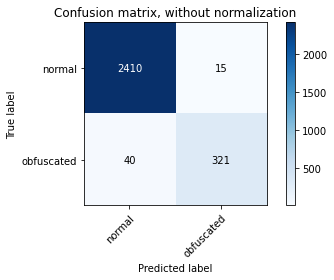

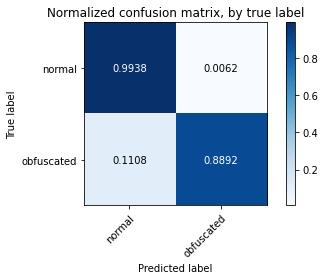

In [13]:
# Plot fancy confusion matrix
# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=4)


# Pretty plot non-normalized confusion matrix
plot_confusion_matrix(test_labels, predicted_labels, classes=['normal','obfuscated'],
                      title='Confusion matrix, without normalization')

# Pretty plot normalized confusion matrix
plot_confusion_matrix(test_labels, predicted_labels, classes=['normal','obfuscated'], normalize=True,
                      title='Normalized confusion matrix, by true label')

from matplotlib import rcParams
rcParams['figure.figsize'] = [6,6]
plt.show()

### Inspect misclassified examples
By looking at those examples that were misclassified, we can better understand what the classifier has learned and how it could potentially be improved. In our case, each misclassified example is either (i) a message marked as 'spam' although it was actually 'ham' (i.e., a false positive) or (ii) a message marked as 'ham' although it was actually 'spam' (i.e., a false negative). It is largely domain-dependent to determine how to balance the cost of a false negative versus a false positive, and which we'd prefer our model to try to avoid.

In [ ]:
# Show misclassified examples
test_examples = pd.DataFrame({'test_labels': test_labels, 'predicted_labels': predicted_labels}).merge(df['sms_message'], left_index = True, right_index=True)

misclassified_fp = test_examples.query('(test_labels != predicted_labels) & (predicted_labels == "spam")')
misclassified_fn = test_examples.query('(test_labels != predicted_labels) & (predicted_labels == "ham")')

print('False positives (marked as spam, but actually ham):')
print(misclassified_fp['sms_message'].to_string(index=False))
print('\n')
print('False negatives (marked as ham, but actually spam):')
print(misclassified_fn['sms_message'].to_string(index=False))

### Explain model results by analyzing feature importance
Finally, we would like to inspect our trained model more closely to try to determine how it is making its predictions. This largely depends entirely on the model we are training, although there are several model-agnostic methods for interpretability that we won't discuss here.

#### Random forest (or decision trees)

In [ ]:
import pandas as pd
import random

if classifier_type in ['decision tree', 'random forest']:

    # Compute feature importances
    importance_scores = classifier.feature_importances_
    feature_importances = pd.DataFrame(importance_scores, index = features,
                                columns=['importance']).sort_values('importance', ascending=False)

    print('Top features based on (averaged) Gini index:')
    print(feature_importances[:20])

    # Extract (sample) decision tree
    if classifier_type == 'decision tree':
        sample_tree = classifier
    if classifier_type == 'random forest':
        sample_tree = random.choice(classifier.estimators_)

    # Plot decision tree
    from sklearn.tree import plot_tree
    plot_tree(sample_tree, feature_names=features, filled=True)

    from matplotlib import rcParams
    rcParams['figure.figsize'] = [18,10]
    print('\n')
    print('(Sampled) decision tree:')
    plt.show()

else:
    print("Invalid: Train tree-based classifier.")

#### Logistic regression

In [ ]:
import pandas as pd
import numpy as np

if classifier_type == 'logistic regression':

    # CompUte feature importances
    importance_scores = np.transpose(classifier.coef_)
    feature_importances = pd.DataFrame(importance_scores, index = features,
                                columns=['importance']).sort_values('importance', ascending=False)

    # Display most important features for each class
    print('Features that favor spam class:')
    print(feature_importances[:10])
    print('\n')
    print('Features that favor ham class:')
    print(feature_importances[-10:])

else:
    print("Invalid: Train logistic regression classifier.")